# Workshop Developing AI Agents with AMD GPUs: Build Your OpenManus Agent with MCPs using vLLM, and AMD MI300X GPU

Welcome to this hands-on workshop! Throughout this tutorial, we'll leverage AMD GPUs and **Model Context Protocol (MCP)** ,an open standard for exposing LLM tools via API, to deploy powerful language models like Qwen3. Key components:
- 🖥️ **vLLM** for GPU-optimized inference
- 🛠️ **OpenManus** for agent/tool management
- 🔌 **MCP Servers** for pre-built tool integration

You'll learn how to set up your environment, deploy large language models like Qwen3, connect them to real-world tools using MCP, and build a conversational agent capable of reasoning and taking actions.

By the end of this workshop, you’ll have built an AI-powered Airbnb assistant agent—one that can find a place to stay based on your preferences like location, budget, and travel dates.

Let’s dive in!

## Table of Contents

- [Step 1: Launching vLLM Server on AMD GPUs](#step1)
- [Step 2: Installing Dependencies](#step2)
- [Step 3: Create a simple instance of OpenManus](#step3)
- [Step 4: Tsing MCP server for OpenManus Agent](#step4)
- [Step 5: Challenge with Prize](#step5)

<a id="step1"></a>

## Step 1: Launch a vLLM Server

In this workshop we are going to use [vLLM](https://github.com/vllm-project/vllm) as our inference serving engine. vLLM provides many benefits such as fast model execution, extensive list of supported models, easy to use, and best of all it's open-source. 

### Deploy Qwen3-30B-A3B Model with vLLM


Time to start your vLLM server and creating an end-point for your LLM. Let's open a terminal using your Jupyter server. Then run the following command in this terminal to start the vLLM server:

> ⚠️ **IMPORTANT:** The following block is **not** a notebook cell.  
> Open a new Jupyter tab by clicking on `+`:


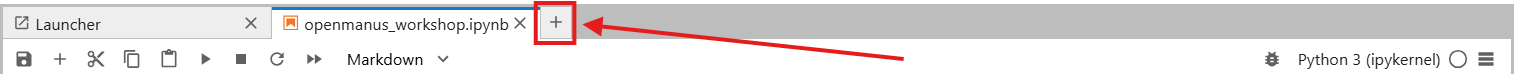

> Find the **terminal icon** in your Jupyter environment (not a notebook cell): 

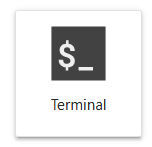

> **paste this command to launch your vLLM server:**


```bash
VLLM_USE_TRITON_FLASH_ATTN=0 \
vllm serve Qwen/Qwen3-30B-A3B \
    --served-model-name Qwen3-30B-A3B \
    --api-key abc-123 \
    --port 8000 \
    --enable-auto-tool-choice \
    --tool-call-parser hermes \
    --trust-remote-code
```


Open another terminal and monitor the GPU utilization by running this command:

```bash
watch rocm-smi
```

Upon successful launch, your server should be accepting incoming traffic through an OpenAI-compatible API. You must see a message such as the one below before moving on:

<span style="color:red">
INFO: Started server process [210]<br>
INFO: Waiting for application startup.<br>
INFO: Application startup complete.
</span>

Let's set some environment variables for our server so we can use throughout this tutorial:

In [ ]:
import os

BASE_URL = f"http://localhost:8000/v1"

os.environ["BASE_URL"]    = BASE_URL
os.environ["OPENAI_API_KEY"] = "abc-123"   

print("Config set:", BASE_URL)

We can verify your model is available at the `BASE_URL` we just set by running the following command.

In [ ]:
!curl http://localhost:8000/v1/models -H "Authorization: Bearer $OPENAI_API_KEY"

Congratulations, you now just launched a powerful server that can serve any incoming request and allowing you to build amazing applications. Wasn't that easy?🎉 

<a id="step2"></a>

## Step 2: Installing Dependencies

<span style="color:red"><strong>⚠️ WARNING:</strong> You must run the model in Step 1 successfully before moving to this step.</span>

We are going to use `OpenManus`. Let's install the dependencies. Note, ideally in your :

In [ ]:
%%bash
git clone https://github.com/FoundationAgents/OpenManus.git
cd OpenManus
apt remove --purge python3-blinker -y
pip install browsergym~=0.13.3 --no-deps
pip install browser-use~=0.1.40
pip install -r requirements.txt 
playwright install-deps
playwright install

Change to our project directoy and let's start experimenting.

In [ ]:
import os

# Change to your desired directory
os.chdir('OpenManus')

# Verify you're in the new directory
print("Current directory:", os.getcwd())


<a id="step3"></a>

## Step 3: Create a simple instance of OpenManus Agent

Let's start by creating a config file and connect OpenAI Compatible endpoint. 


In [ ]:
config_path = "./config/config.toml"

config_content = """
[llm]
model = "Qwen3-30B-A3B"
base_url = "http://localhost:8000/v1"
api_key = "abc-123"
max_tokens = 4096
temperature = 0.0

[browser]
headless = true

[mcp]
server_reference = "app.mcp.server"

[runflow]
use_data_analysis_agent = false
"""

# Write the cleaned config
with open(config_path, "w") as f:
    f.write(config_content.strip() + "\n")

print(f"Wrote cleaned config to: {config_path}")

Let's test the OpenManus agent.

In [ ]:
!python main.py --prompt "I am in San Jose, I want to make a Mapo Tofu. Tell me where to get all the ingredients I need."

Next, let's see how we can get some realtime data from our agent.

In [ ]:
!python main.py --prompt "what is the date today"

That is great, OpenManus attempts using the tools it has at its disposal to get this information. What if you wanted to use ready to use MCP server? Let's see how we can do this in the next section. 



<a id="step4"></a>

## Step 4: Adding a MCP server

Now that we learned how to create a custom tool and provide the agent access to this tool. Let's now explore a trendy topic of [Model Context Protocol](https://modelcontextprotocol.io/introduction). We are going to explore how we can replace our custom tool with a simple MCP server that can serve our agent and provide similar information.

**Why MCP?** MCP servers provide:
- ✅ Standardized API interfaces
- 🔄 Reusable across projects
- 📦 Pre-built functionality

Let's replace our custom time tool with an official MCP time server:

### Installing Time MCP Server

We are going to start by installing this MCP server:


In [ ]:
!pip install -q mcp-server-time

Let's create our MCP config file. Start by creating the variable.

In [ ]:
mcp_info = {
  "mcpServers": {
    "time": {
      "type": "stdio",
      "command": "python",
      "args": ["-m", "mcp_server_time", "--local-timezone=America/New_York"]
    }
  }
}

Then write it as `mcp.json` under `config` directory.

In [ ]:
## create the mcp.json under OpenManus/config/mcp.json
import json

# Write mcp.json file
with open("config/mcp.json", "w") as f:
    json.dump(mcp_info, f, indent=2)

Great, let's see if the agent can use the MCP to give us the correct time now.

In [ ]:
!python main.py --prompt "Tell me the time in San Francisco"


Tadaa! Now you have officially used an MCP server to power-up your agent. In the next section we show how you can your turn many ideas into real working projects by using 100s of free or paid MCP servers available today.



<a id="step6"></a>

## Step 5: Turn your agent to Multi-MCP user

As we experience in the last section, MCP servers are really easy to use and they provide a standard way of providing LLMs the tools we need. There are already thousands of MCP servers available for us to use. There are some MCP trackers that you can always use to find out about available servers. Here are some for your reference:
- https://github.com/modelcontextprotocol/servers
- https://mcp.so/




In this part of the workshop we are going to build an agent that can help you browse available Airbnbs to book. We can now build on top of what we have so far and add an open-source Airbnb MCP server to our agent. To do so, let's start by defining our Airbnb server.

In [ ]:
# Install Node.js 18 via NodeSource
!curl -fsSL https://deb.nodesource.com/setup_18.x | sudo -E bash -
!apt install -y nodejs

Let's verify our installation.

In [ ]:
!node -v && npm -v && npx --version

Let's update our agent.

In [ ]:
mcp_info = {
    "mcpServers": {
        "time": {
            "type": "stdio",
            "command": "python",
            "args": [
                "-m",
                "mcp_server_time",
                "--local-timezone=America/New_York"
            ]
        },
        "airbnb": {
            "type": "stdio", 
            "command": "npx",
            "args": [
                "-y",
                "@openbnb/mcp-server-airbnb",
                "--ignore-robots-txt"
            ]
        }
    }
}

Now we need to write our updsated config file under `config` directory.

In [ ]:
## create the mcp.json under OpenManus/config/mcp.json
import json
# Write mcp.json file
with open("config/mcp.json", "w") as f:
    json.dump(mcp_info, f, indent=2)

Finally, let's try our agent and see if it can browse through Airbnb listings.Time to test.

In [ ]:
!python main.py --prompt "Find a place to stay in Vancouver for next Sunday for 3 nights for 2 adults?"



<a id="step7"></a>

## Step 7: Challenge - Expand the Agent

**Task:** Add weather integration using an appropiate MCP server:
1. Launch weather MCP server
2. Add to agent's tools
3. Make agent suggest best travel dates based on weather

**Judging Criteria:**
✅ Functional weather integration
🎯 Logical tool selection
💡 Creative use of multiple tools

<span style="color:red"><strong>⚠️ FINAL STEP:</strong> When you're done, make sure to stop the model and free GPU resources by pressing <code>Ctrl+C</code> in the terminal where the server is running.</span>
